<a href="https://colab.research.google.com/github/anvaribs/UT-COE-321K/blob/master/Fenics_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COE 321K: Template FEniCS notebook



This notebook is meant to be a template for you to use while coding using the fenics framework. The first cell is meant to be run as-is and takes care of configuring the environment for you. You can start from the second cell and implement the solver for your own problem.

### Setup environment

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 

def plot_compact(u, t, stepcounter, QQ, pl, ax, soltit = "Velocity"): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(sqrt(inner(u, u)), QQ)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1)
    pp = plot(uEuclidnorm, cmap="coolwarm")
    plt.title("%s at t=%f" % (soltit, t)) # Plot norm of solution
    if t == 0:
      plt.axis(G)
      plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    if t == 0:
      plot(QQ.mesh())
      plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)



In [10]:
import matplotlib.pyplot as plt
from __future__ import print_function
import dolfin
print(dolfin.__version__)
%matplotlib inline
from fenics import *
plt.style.use('default')

2018.1.0


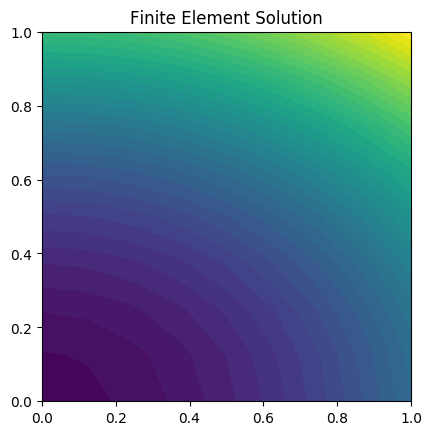

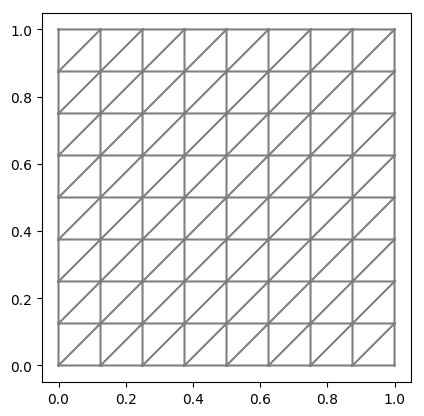

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


In [11]:
## %load ../fenics-tutorial/pub/python/vol1/ft01_poisson.py
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""


# Create mesh and define function space (128 linear elements)
# in this case error_max = 1.33226762955e-15
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)  # 'P' implies the standard lagrange Family of element

# Create mesh and define function space (2 x (20x20) cubic lagrange elements)
# in this case error_max = 2.06612504883e-12
# mesh = UnitSquareMesh(20,20)
# V = FunctionSpace(mesh, 'P', 3)  # 'P' implies the standard lagrange Family of element


# Define boundary condition
# we use deggree = 2 so that u_D may represent the 
# exact quadratic solution to our test problem.

u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

# Not a good programming practice:
# def boundary(x):
#     return x[0] == 0 or x[1] == 0 or x[0] == 1 or x[1] == 1


# tol = 1E-14    # DOLFIN_EPS can also be used
# def boundary(x):
#     return abs(x[0]) < tol or abs(x[1]) < tol \
#         or abs(x[0] - 1) < tol or abs(x[1] - 1) < tol

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Expression(’-6’, degree=0)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u, title='Finite Element Solution')
plt.show()
plot(mesh)
plt.show()

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
# since the exact solution is quadratic and the FEM
# solution is piecewise linear, the error would be non-zero
error_L2 = errornorm(u_D, u, 'L2')   

# Compute maximum error at vertices
# We expect this error to be zero within machine precision
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
plt.show()


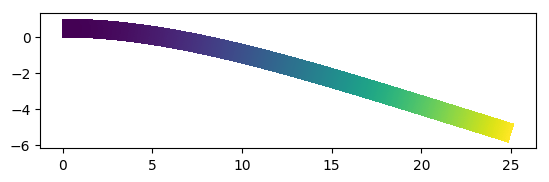

Maximal deflection: 0.0058637525873285025
Beam theory deflection: 0.005859375
Stress at (0,H): [ 1.72741309 -0.22361947 -0.22361947  0.40196748]


In [12]:
#
# ..    # gedit: set fileencoding=utf8 :
# .. raw:: html
#
#  <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><p align="center"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png"/></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a></p>
#
#
# .. _LinearElasticity2D:
#
# =========================
#  2D linear elasticity
# =========================
#
#
# Introduction
# ------------
#
# In this first numerical tour, we will show how to compute a small strain solution for
# a 2D isotropic linear elastic medium, either in plane stress or in plane strain,
# in a tradtional displacement-based finite element formulation. The corresponding
# file can be obtained from :download:`2D_elasticity.py`.
#
# .. seealso::
#
#  Extension to 3D is straightforward and an example can be found in the :ref:`ModalAnalysis` example.
#
# We consider here the case of a cantilever beam modeled as a 2D medium of dimensions
# :math:`L\times  H`. Geometrical parameters and mesh density are first defined
# and the rectangular domain is  generated using the ``RectangleMesh`` function.
# We also choose a criss-crossed structured mesh::

from __future__ import print_function
from fenics import *

L = 25.
H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")


# Constitutive relation
# ---------------------
#
# We now define the material parameters which are here given in terms of a Young's
# modulus :math:`E` and a Poisson coefficient :math:`\nu`. In the following, we will
# need to define the constitutive relation between the stress tensor :math:`\boldsymbol{\sigma}`
# and the strain tensor :math:`\boldsymbol{\varepsilon}`. Let us recall
# that the general expression of the linear elastic isotropic constitutive relation
# for a 3D medium is given by:
#
# .. math::
#  \boldsymbol{\sigma} = \lambda \text{tr}(\boldsymbol{\varepsilon})\mathbf{1} + 2\mu\boldsymbol{\varepsilon}
#  :label: constitutive_3D
#
# for a natural (no prestress) initial state where the Lamé coefficients are given by:
#
# .. math::
#  \lambda = \dfrac{E\nu}{(1+\nu)(1-2\nu)}, \quad \mu = \dfrac{E}{2(1+\nu)}
#  :label: Lame_coeff
#
# In this demo, we consider a 2D model either in plane strain or in plane stress conditions.
# Irrespective of this choice, we will work only with a 2D displacement vector :math:`\boldsymbol{u}=(u_x,u_y)`
# and will subsequently define the strain operator ``eps`` as follows::

def eps(v):
    return sym(grad(v))

# which computes the 2x2 plane components of the symmetrized gradient tensor of
# any 2D vectorial field. In the plane strain case, the full 3D strain tensor is defined as follows:
#
# .. math::
#  \boldsymbol{\varepsilon} = \begin{bmatrix} \varepsilon_{xx} & \varepsilon_{xy} & 0\\
#  \varepsilon_{xy} & \varepsilon_{yy} & 0 \\ 0 & 0 & 0\end{bmatrix}
#
# so that the 2x2 plane part of the stress tensor is defined in the same way as for the 3D case
# (the out-of-plane stress component being given by :math:`\sigma_{zz}=\lambda(\varepsilon_{xx}+\varepsilon_{yy})`.
#
# In the plane stress case, an out-of-plane strain component :math:`\varepsilon_{zz}`
# must be considered so that :math:`\sigma_{zz}=0`. Using this condition in the
# 3D constitutive relation, one has :math:`\varepsilon_{zz}=-\dfrac{\lambda}{\lambda+2\mu}(\varepsilon_{xx}+\varepsilon_{yy})`.
# Injecting into :eq:`constitutive_3D`, we have for the 2D plane stress relation:
#
# .. math::
#  \boldsymbol{\sigma} = \lambda^* \text{tr}(\boldsymbol{\varepsilon})\mathbf{1} + 2\mu\boldsymbol{\varepsilon}
#
# where :math:`\boldsymbol{\sigma}, \boldsymbol{\varepsilon}, \mathbf{1}` are 2D tensors and with
# :math:`\lambda^* = \dfrac{2\lambda\mu}{\lambda+2\mu}`. Hence, the 2D constitutive relation
# is identical to the plane strain case by changing only the value of the Lamé coefficient :math:`\lambda`.
# We can then have::

E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

# .. note::
#  Note that we used the variable name ``lmbda`` to avoid any confusion with the
#  lambda functions of Python
#
#  We also used an intrinsic formulation of the constitutive relation. Example of
#  constitutive relation implemented with a matrix/vector engineering notation
#  will be provided in the :ref:`OrthotropicElasticity` example.
#
#
# Variational formulation
# -----------------------
#
# For this example, we consider a continuous polynomial interpolation of degree 2
# and a uniformly distributed loading :math:`\boldsymbol{f}=(0,-f)` corresponding
# to the beam self-weight. The continuum mechanics variational formulation (obtained
# from the virtual work principle) is given by:
#
# .. math::
#  \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\Omega}
#  \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) d\Omega
#  = \int_{\Omega} \boldsymbol{f}\cdot\boldsymbol{v}  d\Omega \quad \forall\boldsymbol{v} \in V
#
# which translates into the following FEniCS code::

rho_g = 1e-3
f = Constant((0,-rho_g))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx


# Resolution
# ----------
#
# Fixed displacements are imposed on the left part of the beam, the ``solve``
# function is then called and solution is plotted by deforming the mesh::

def left(x, on_boundary):
    return near(x[0],0.)

bc = DirichletBC(V, Constant((0.,0.)), left)

u = Function(V, name="Displacement")
solve(a == l, u, bc)

plot(1e3*u, mode="displacement")
plt.show()

# The (amplified) solution should look like this:
#
# .. image:: cantilever_deformed.png
#    :scale: 15%
#
#
# Validation and post-processing
# ------------------------------
#
# The maximal deflection is compared against the analytical solution from
# Euler-Bernoulli beam theory which is here :math:`w_{beam} = \dfrac{qL^4}{8EI}`::

print("Maximal deflection:", -u(L,H/2.)[1])
print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))

# One finds :math:`w_{FE} = 5.8638\text{e-3}` against :math:`w_{beam} = 5.8594\text{e-3}`
# that is a 0.07% difference.
#
#
# The stress tensor must be projected on an appropriate function space in order to
# evaluate pointwise values or export it for Paraview vizualisation. Here we choose
# to describe it as a (2D) tensor and project it onto a piecewise constant function
# space::

Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
sig = Function(Vsig, name="Stress")
sig.assign(project(sigma(u), Vsig))
print("Stress at (0,H):", sig(0, H))

# Fields can be exported in a suitable format for vizualisation using Paraview.
# VTK-based extensions (.pvd,.vtu) are not suited for multiple fields and parallel
# writing/reading. Prefered output format is now .xdmf::

file_results = XDMFFile("comet_elasticity_results/elasticity_results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(sig, 0.)
